<a href="https://colab.research.google.com/github/zoetice/data-science/blob/main/Copy_of_Unit7ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting Curves: Concepts

What you'll do:

- Answer questions about what a GP is, and its relationship to GLMs and splines.
- Practice applying each of: polynomial modeling, b splines, and GPs
- You'll get a chance to read about and try to comprehend a more standard implementation of a GP.

Have fun!

**Task1**:

Why would you ever want to include a polynomial element in a model you built? What's the benefit of using polynomials to model?

Polynomial models can improve the fit of a model when the data has a more complicated relationship

**Task2**:

Why would you ever NOT want to include a polynomial element in a model you built?

they have the drawback of overfitting to the given data, and predicting poorly, if you jack up the degree too much. if predictions stop improving, then stop increasing the complexity of your model


**Task3**:

What's the point of using b splines?

B splines are great way to get the flexibility of polynomial regression, with less overfitting.

**Task4**:

Describe what a Gaussian Process is, in your own words. *Don't worry about being correct, just try to explain it to yourself*. I will not grade this question for accuracy.

the gaussian process is a non-parametric Bayesian machine learning method. It defines a probability distribution over possible functions and models data by assuming any finite set of function values follows a joint normal distribution.

**Task5**:

Fit three models to the howell data (from Unit5ExercisesSF): polynomial, b splines, and Gaussian Process.

Plot the posterior predictive check on a scatter plot, as is standard/required.

Hint: Distributional models (variable variance) work better on the howell data.


In [ ]:
!pip install preliz
!pip install bambi

In [ ]:
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import preliz as pz
import pymc as pm
import bambi as bmb

In [ ]:
howell = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/howell.csv')
howell

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
539,145.415,31.127751,17.0,1
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0
542,71.120,8.051258,0.0,1


In [ ]:
model_poly_1 = bmb.Model("weight ~ height", howell, family="negativebinomial")
idata_poly_1 = model_poly_1.fit()

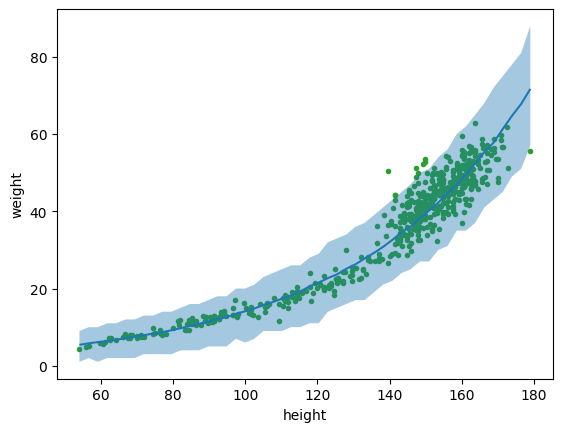

In [ ]:
bmb.interpret.plot_predictions(model_poly_1, idata_poly_1, "height", pps=True)
plt.plot(howell.height, howell.weight, "C2.", zorder=-3)

In [ ]:
num_knots = 6
knots = np.linspace(howell.height.min(), howell.height.max(), num_knots+2)[1:-1]
model_spline = bmb.Model("weight ~ bs(height, degree=3, knots=knots)", howell, family="negativebinomial")
idata_spline = model_spline.fit()

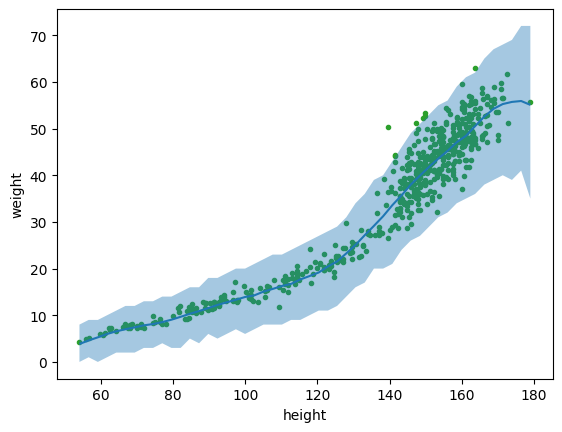

In [ ]:
bmb.interpret.plot_predictions(model_spline, idata_spline, "height", pps= True)
plt.plot(howell.height, howell.weight, "C2.", zorder=-3)

In [ ]:
weight = howell["weight"].values
height = howell["height"].values[:,None]

In [ ]:
def get_ig_params(x_vals, l_b=None, u_b=None, mass=0.96, plot=False):
    """
    Returns a weakly informative prior for the length-scale parameter of the GP kernel.
    """

    differences = np.abs(np.subtract.outer(x_vals, x_vals))
    if l_b is None:
        l_b = np.min(differences[differences != 0]) * 2
    if u_b is None:
        u_b = np.max(differences) / 1.5

    dist = pz.InverseGamma()
    pz.maxent(dist, l_b, u_b, mass, plot=plot)

    return dict(zip(dist.param_names, dist.params))

In [ ]:
m, c = pm.gp.hsgp_approx.approx_hsgp_hyperparams(
    x_range=[0, 24], lengthscale_range=[1, 30], cov_func="ExpQuad"
)

print("Recommended smallest number of basis vectors (m):", m)
print("Recommended smallest scaling factor (c):", np.round(c, 1))

In [ ]:
with pm.Model() as model_hsgp:
    #prior for our smoothness parameter
    ℓ = pm.InverseGamma('ℓ', **get_ig_params(height))

    #this is our kernal, which decides how our points relate to one another
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ)
    #this specfices that we're using an HSGP
    gp = pm.gp.HSGP(m=[168], c=8.0, cov_func=cov)

    #f is for function, as in the function we use to transform our data
    f = gp.prior('f', X=height)
    #prior for the neg binomial
    α = pm.HalfNormal('α', 1)
    #likelihood
    y = pm.NegativeBinomial("y", np.exp(f), α, observed=weight)

    idata_hsgp = pm.sample()

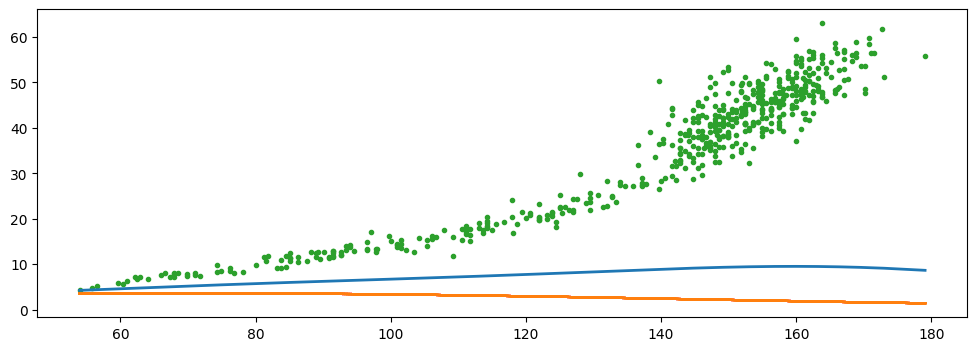

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(12, 4))
#plot raw data
ax.plot(howell["height"].values, howell["weight"].values, "C2.")

#grab posterior
f = az.extract(idata_hsgp, group="posterior", var_names="f")


idx = np.argsort(howell["height"].values)
#plot samples of the posterior
ax.plot(howell["height"].values[idx], np.exp(f.values[idx,:100]), alpha=0.25, color="C1")
#plot posterior mean
ax.plot(howell["height"].values[idx], np.exp(f.values[idx].mean(1)), color="C0", lw=2)

**Task6**:

Read the article on the pymc website about GP implementation on the Mauna Loa CO$_{2}$ data combined with CO$_{2}$ ice core data from the south pole.
[Link here.](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-MaunaLoa2.html)

Write down one thing you learned about GPs from reading the article.

Note: You probably won't understand much in this article--I had to read it about five times before I figured out what was going on. The points of this task are to: hammer home that good GP implementations are extremely technical, and increasure your exposure to the kinds of problems traditional GPs are good at solving.

You can fit fully Bayesian GPs with NUTS

**Task7**:

Describe your favorite graph from the article in the previous task with as much technical detail as you can muster.

Explain why its your favorite.

My favorite graph from the article is the first time offset prior graph that is made up of blue verticle lines that are vey symetrical, creating a hill looking graph. I like this graph because it is pretty